In [1]:
%load_ext autoreload
%autoreload 2
import src.data_proc as data_proc

import numpy as np
import pandas as pd
import sys
import os
import gc
import random
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
pd.options.display.float_format

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
"""
    Drop id and label columns + Feature selection for LightGBM
"""
def lgb_drop_features(features):
    # id and label (not features)
    unused_feature_list = ['parcelid', 'logerror']

    # too many missing (LightGBM is robust against bad/unrelated features, so this step might not be needed)
    missing_list = ['framing_id', 'architecture_style_id', 'story_id', 'perimeter_area', 'basement_sqft', 'storage_sqft']
    unused_feature_list += missing_list

    # chosen based on LightGBM feature importance
    bad_feature_list = ['fireplace_flag', 'deck_id', 'pool_unk_1', 'construction_id', 'county_id', 'fips']
    unused_feature_list += bad_feature_list

    # really hurts performance
    unused_feature_list += ['county_landuse_code_id', 'zoning_description_id']

    return features.drop(unused_feature_list, axis=1, errors='ignore')

# Data loading

In [3]:
%%time
# Read DataFrames from hdf5
features_2016 = pd.read_hdf('hdf5/features.h5', 'features_2016')  # All features except for datetime for 2016
features_2017 = pd.read_hdf('hdf5/features.h5', 'features_2017')  # All features except for datetime for 2017
train = pd.read_hdf('hdf5/train.h5', 'train')  # Concatenated 2016 and 2017 training data with labels

CPU times: user 10.9 s, sys: 6.12 s, total: 17 s
Wall time: 19.1 s


# Training and Tuning

In [16]:
lgb_features = lgb_drop_features(train)
print("Number of features for LightGBM: {}".format(len(lgb_features.columns)))
lgb_features.head(10)

Number of features for LightGBM: 69


,cooling_id,bathroom_cnt,bedroom_cnt,quality_id,floor1_sqft,finished_area_sqft_calc,floor1_sqft_unk,base_total_area,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,neighborhood_id,region_zip,room_cnt,bathroom_small_cnt,unit_cnt,patio_sqft,year_built,story_cnt,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,avg_garage_size,property_tax_per_sqft,location_1,location_2,location_3,location_4,missing_finished_area,missing_total_area,missing_bathroom_cnt_calc,derived_room_cnt,avg_area_per_room,derived_avg_area_per_room,region_zip-groupcnt,region_zip-lot_sqft-diff,region_zip-lot_sqft-percent,region_zip-year_built-diff,region_zip-finished_area_sqft_calc-diff,region_zip-finished_area_sqft_calc-percent,region_zip-tax_structure-diff,region_zip-tax_structure-percent,region_zip-tax_land-diff,region_zip-tax_land-percent,region_zip-tax_property-diff,region_zip-tax_property-percent,region_zip-property_tax_per_sqft-diff,region_zip-property_tax_per_sqft-percent,year,month,quarter
0,0,2.0,3.0,4.0,NaN,1684.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,31817.0,96370.0,0.0,NaN,1.0,NaN,1959.0,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,NaN,3.999929,-84207544.0,152769536.0,-24963276.0,93525260.0,0.0,1.0,0.0,5.0,NaN,336.799988,14719.0,-13398.968750,-0.640273,-3.998413,-247.725464,-0.128241,-50475.015625,-0.291377,5.102642e+04,0.273762,2047.035645,0.436576,1.521634,0.613984,0,1,1
1,-1,3.5,4.0,NaN,NaN,2263.0,NaN,NaN,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,NaN,96962.0,0.0,1.0,NaN,NaN,2014.0,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,234.0,4.486531,-84009432.0,151345664.0,-25170656.0,92506896.0,0.0,1.0,0.0,7.5,NaN,301.733337,17682.0,-2715.032715,-0.427024,35.535156,526.538208,0.303225,213678.171875,1.609267,1.630267e+04,0.073182,6339.847656,1.662618,2.160548,0.928875,0,1,1
2,0,3.0,2.0,4.0,NaN,2217.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,275411.0,96293.0,0.0,NaN,1.0,NaN,1940.0,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,NaN,5.180190,-84038720.0,152311344.0,-24951204.0,93223828.0,0.0,1.0,0.0,5.0,NaN,443.399994,4422.0,-14927.021484,-0.566490,-12.917847,-173.867432,-0.072721,-236757.281250,-0.792490,-4.276051e+05,-0.880721,1845.573242,0.191471,1.178391,0.294465,0,1,1
3,0,2.0,2.0,4.0,NaN,839.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,54300.0,96222.0,0.0,NaN,1.0,NaN,1987.0,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,NaN,3.633778,-84553200.0,152064800.0,-25398700.0,92910300.0,0.0,1.0,0.0,4.0,NaN,209.750000,7293.0,-43346.804688,-0.379550,21.690186,-782.150757,-0.482466,30903.765625,0.219777,-1.294408e+05,-0.638259,-1337.844971,-0.304986,0.830251,0.296145,0,1,1
4,-1,2.5,4.0,NaN,NaN,2283.0,NaN,NaN,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,1.0,230,60590424.0,17686.0,NaN,96961.0,8.0,1.0,NaN,NaN,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,299.0,2.404275,-84214592.0,151185872.0,-25364472.0,92335760.0,0.0,1.0,0.0,6.5,285.375000,351.230774,9875.0,-1155.377441,-0.161470,0.695679,244.801147,0.120107,-50359.125000,-0.228975,-1.959772e+05,-0.425156,-2742.872070,-0.333203,-1.339566,-0.357805,0,1,1
5,0,4.0,4.0,1.0,NaN,3067.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,230,60376212.0,29712.0,NaN,96109.0,0.0,NaN,1.0,NaN,1982.0,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13,NaN,8.844660,-84532680.0,152272864.0,-25331296.0,93071472.0,0.0,1.0,0.0,8.0,NaN,383.375000,6257.0,-5556.242188,-0.672323,16.456299,1096.405884,0.556383,606664.500000,2.214221,1.006336

In [17]:
# Prepare training and cross-validation data
lgb_label = train.logerror.astype(np.float32)
print(lgb_label.head())

# Transform to Numpy matrices
lgb_X = lgb_features.values
lgb_y = lgb_label.values

# Perform shuffled train/test split
np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lgb_X, lgb_y, test_size=0.2)

# Remove outlier examples from X_train and y_train; Keep them in X_val and y_val for proper cross-validation
outlier_threshold = 0.4
mask = (abs(y_train) <= outlier_threshold)
X_train = X_train[mask, :]
y_train = y_train[mask]

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float32
X_train shape: (131426, 69)
y_train shape: (131426,)
X_val shape: (33578, 69)
y_val shape: (33578,)


In [18]:
# Specify feature names and categorical features for LightGBM
feature_names = [s for s in lgb_features.columns]
categorical_features = ['cooling_id', 'heating_id', 'landuse_type_id', 'year', 'month', 'quarter']

categorical_indices = []
for i, n in enumerate(lgb_features.columns):
    if n in categorical_features:
        categorical_indices.append(i)
print(categorical_indices)

[0, 13, 21, 66, 67, 68]


In [44]:
# LightGBM parameters
params = {}

params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_threads'] = 4  # set to number of real CPU cores for best performance

params['boosting_type'] = 'gbdt'
params['num_boost_round'] = 2000
params['learning_rate'] = 0.003  # shrinkage_rate
params['early_stopping_rounds'] = 30  # Early stopping based on validation set performance

# Control tree growing
params['num_leaves'] = 127  # max number of leaves in one tree (default 31)
params['min_data'] = 150  # min_data_in_leaf
params['min_hessian'] = 0.001  # min_sum_hessian_in_leaf (default 1e-3)
params['max_depth'] = -1  # limit the max depth of tree model, defult -1 (no limit)
params['max_bin'] = 255  # max number of bins that feature values are bucketed in (small -> less overfitting, default 255)
params['sub_feature'] = 0.5    # feature_fraction (small values => use very different submodels)

# Row subsampling (speed up training and alleviate overfitting)
params['bagging_fraction'] = 0.7
params['bagging_freq'] = 50  # perform bagging at every k iteration

# Constraints on categorical features
params['min_data_per_group'] = 100  # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 15.0  # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params['lambda_l1'] = 0.0
params['lambda_l2'] = 0.0

# Random seeds (keep default values)
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [43]:
# Train LightGBM
lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

np.random.seed(42)
random.seed(36)
clf = lgb.train(params, lgb_train_set, verbose_eval=True,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=categorical_indices)

# Evaluate on validation set
print("Train score: {}".format(abs(clf.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(clf.predict(X_val) - y_val).mean() * 100))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 13, 21, 66, 67, 68]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's l1: 0.0525584	val's l1: 0.0695856
[2]	train's l1: 0.0525533	val's l1: 0.0695817
[3]	train's l1: 0.0525481	val's l1: 0.0695776
[4]	train's l1: 0.0525429	val's l1: 0.0695737
[5]	train's l1: 0.0525378	val's l1: 0.0695696
[6]	train's l1: 0.0525331	val's l1: 0.0695662
[7]	train's l1: 0.0525281	val's l1: 0.0695626
[8]	train's l1: 0.0525229	val's l1: 0.0695589
[9]	train's l1: 0.0525182	val's l1: 0.0695553
[10]	train's l1: 0.0525134	val's l1: 0.0695519
[11]	train's l1: 0.0525088	val's l1: 0.0695484
[12]	train's l1: 0.0525043	val's l1: 0.0695448
[13]	train's l1: 0.0524997	val's l1: 0.0695416
[14]	train's l1: 0.0524945	val's l1: 0.0695378
[15]	train's l1: 0.0524897	val's l1: 0.0695344
[16]	train's l1: 0.0524851	val's l1: 0.0695308
[17]	train's l1: 0.0524804	val's l1: 0.0695278
[18]	train's l1: 0.052476	val's l1: 0.0695247
[19]	train's l1: 0.0524713	val's l1: 0.0695214
[20]	train's l1: 0.0524664	val's l1: 0.0695181
[21]	train's l1: 0.0524615	val's l1: 0.0695143
[22]	train's l1: 0.0524

[185]	train's l1: 0.0518731	val's l1: 0.0691289
[186]	train's l1: 0.0518702	val's l1: 0.0691274
[187]	train's l1: 0.0518675	val's l1: 0.0691258
[188]	train's l1: 0.0518645	val's l1: 0.0691241
[189]	train's l1: 0.0518619	val's l1: 0.0691226
[190]	train's l1: 0.0518591	val's l1: 0.0691208
[191]	train's l1: 0.0518566	val's l1: 0.0691193
[192]	train's l1: 0.0518538	val's l1: 0.0691178
[193]	train's l1: 0.0518511	val's l1: 0.0691164
[194]	train's l1: 0.0518482	val's l1: 0.0691149
[195]	train's l1: 0.0518456	val's l1: 0.0691135
[196]	train's l1: 0.051843	val's l1: 0.0691118
[197]	train's l1: 0.0518403	val's l1: 0.0691103
[198]	train's l1: 0.0518377	val's l1: 0.069109
[199]	train's l1: 0.051835	val's l1: 0.0691075
[200]	train's l1: 0.0518323	val's l1: 0.0691057
[201]	train's l1: 0.0518293	val's l1: 0.0691041
[202]	train's l1: 0.0518266	val's l1: 0.0691027
[203]	train's l1: 0.0518236	val's l1: 0.0691011
[204]	train's l1: 0.051821	val's l1: 0.0691
[205]	train's l1: 0.0518183	val's l1: 0.0690985

[356]	train's l1: 0.0514718	val's l1: 0.0689463
[357]	train's l1: 0.0514697	val's l1: 0.0689455
[358]	train's l1: 0.0514676	val's l1: 0.0689446
[359]	train's l1: 0.0514657	val's l1: 0.0689439
[360]	train's l1: 0.051464	val's l1: 0.0689434
[361]	train's l1: 0.0514619	val's l1: 0.0689425
[362]	train's l1: 0.05146	val's l1: 0.068942
[363]	train's l1: 0.0514582	val's l1: 0.0689411
[364]	train's l1: 0.0514564	val's l1: 0.0689402
[365]	train's l1: 0.0514544	val's l1: 0.0689394
[366]	train's l1: 0.0514525	val's l1: 0.0689386
[367]	train's l1: 0.0514506	val's l1: 0.0689381
[368]	train's l1: 0.0514488	val's l1: 0.0689374
[369]	train's l1: 0.0514467	val's l1: 0.0689365
[370]	train's l1: 0.0514446	val's l1: 0.0689356
[371]	train's l1: 0.0514428	val's l1: 0.0689353
[372]	train's l1: 0.0514412	val's l1: 0.0689346
[373]	train's l1: 0.0514393	val's l1: 0.068934
[374]	train's l1: 0.0514374	val's l1: 0.0689329
[375]	train's l1: 0.0514358	val's l1: 0.0689321
[376]	train's l1: 0.051434	val's l1: 0.068931

[530]	train's l1: 0.0511596	val's l1: 0.0688461
[531]	train's l1: 0.0511579	val's l1: 0.0688458
[532]	train's l1: 0.0511564	val's l1: 0.0688455
[533]	train's l1: 0.0511547	val's l1: 0.0688449
[534]	train's l1: 0.0511531	val's l1: 0.0688445
[535]	train's l1: 0.0511517	val's l1: 0.068844
[536]	train's l1: 0.0511502	val's l1: 0.0688435
[537]	train's l1: 0.0511484	val's l1: 0.0688429
[538]	train's l1: 0.0511469	val's l1: 0.0688426
[539]	train's l1: 0.0511451	val's l1: 0.0688422
[540]	train's l1: 0.0511436	val's l1: 0.0688419
[541]	train's l1: 0.0511423	val's l1: 0.0688415
[542]	train's l1: 0.0511408	val's l1: 0.0688413
[543]	train's l1: 0.0511392	val's l1: 0.0688407
[544]	train's l1: 0.0511376	val's l1: 0.0688401
[545]	train's l1: 0.051136	val's l1: 0.0688394
[546]	train's l1: 0.0511343	val's l1: 0.0688391
[547]	train's l1: 0.0511328	val's l1: 0.0688389
[548]	train's l1: 0.0511314	val's l1: 0.0688388
[549]	train's l1: 0.0511297	val's l1: 0.0688379
[550]	train's l1: 0.0511282	val's l1: 0.06

[706]	train's l1: 0.0508991	val's l1: 0.0687863
[707]	train's l1: 0.0508975	val's l1: 0.0687859
[708]	train's l1: 0.0508961	val's l1: 0.0687854
[709]	train's l1: 0.0508946	val's l1: 0.0687852
[710]	train's l1: 0.0508931	val's l1: 0.0687847
[711]	train's l1: 0.0508917	val's l1: 0.0687844
[712]	train's l1: 0.0508902	val's l1: 0.0687842
[713]	train's l1: 0.0508887	val's l1: 0.0687836
[714]	train's l1: 0.0508872	val's l1: 0.0687833
[715]	train's l1: 0.0508858	val's l1: 0.0687828
[716]	train's l1: 0.0508841	val's l1: 0.0687824
[717]	train's l1: 0.0508826	val's l1: 0.068782
[718]	train's l1: 0.0508812	val's l1: 0.0687819
[719]	train's l1: 0.0508799	val's l1: 0.0687816
[720]	train's l1: 0.0508781	val's l1: 0.0687809
[721]	train's l1: 0.0508769	val's l1: 0.0687808
[722]	train's l1: 0.0508753	val's l1: 0.0687807
[723]	train's l1: 0.0508738	val's l1: 0.0687804
[724]	train's l1: 0.0508725	val's l1: 0.06878
[725]	train's l1: 0.0508712	val's l1: 0.0687798
[726]	train's l1: 0.0508699	val's l1: 0.068

[879]	train's l1: 0.0506593	val's l1: 0.0687449
[880]	train's l1: 0.0506581	val's l1: 0.0687449
[881]	train's l1: 0.0506569	val's l1: 0.0687448
[882]	train's l1: 0.0506557	val's l1: 0.0687449
[883]	train's l1: 0.0506542	val's l1: 0.0687447
[884]	train's l1: 0.0506531	val's l1: 0.0687447
[885]	train's l1: 0.0506518	val's l1: 0.0687446
[886]	train's l1: 0.0506504	val's l1: 0.0687445
[887]	train's l1: 0.0506492	val's l1: 0.0687443
[888]	train's l1: 0.0506479	val's l1: 0.0687443
[889]	train's l1: 0.0506466	val's l1: 0.068744
[890]	train's l1: 0.0506453	val's l1: 0.068744
[891]	train's l1: 0.0506441	val's l1: 0.0687439
[892]	train's l1: 0.0506429	val's l1: 0.0687439
[893]	train's l1: 0.0506416	val's l1: 0.0687439
[894]	train's l1: 0.0506404	val's l1: 0.0687439
[895]	train's l1: 0.0506391	val's l1: 0.0687436
[896]	train's l1: 0.0506379	val's l1: 0.0687437
[897]	train's l1: 0.0506367	val's l1: 0.0687434
[898]	train's l1: 0.0506354	val's l1: 0.0687432
[899]	train's l1: 0.0506341	val's l1: 0.06

[1059]	train's l1: 0.0504326	val's l1: 0.0687208
[1060]	train's l1: 0.0504313	val's l1: 0.0687206
[1061]	train's l1: 0.0504301	val's l1: 0.0687202
[1062]	train's l1: 0.0504291	val's l1: 0.06872
[1063]	train's l1: 0.0504277	val's l1: 0.0687199
[1064]	train's l1: 0.0504264	val's l1: 0.0687196
[1065]	train's l1: 0.0504252	val's l1: 0.0687193
[1066]	train's l1: 0.0504241	val's l1: 0.0687196
[1067]	train's l1: 0.0504229	val's l1: 0.0687196
[1068]	train's l1: 0.0504216	val's l1: 0.0687194
[1069]	train's l1: 0.0504203	val's l1: 0.0687192
[1070]	train's l1: 0.050419	val's l1: 0.0687193
[1071]	train's l1: 0.0504178	val's l1: 0.0687191
[1072]	train's l1: 0.0504164	val's l1: 0.068719
[1073]	train's l1: 0.0504151	val's l1: 0.0687189
[1074]	train's l1: 0.0504137	val's l1: 0.0687185
[1075]	train's l1: 0.0504124	val's l1: 0.0687185
[1076]	train's l1: 0.0504113	val's l1: 0.0687182
[1077]	train's l1: 0.05041	val's l1: 0.0687182
[1078]	train's l1: 0.0504091	val's l1: 0.0687183
[1079]	train's l1: 0.05040

[1236]	train's l1: 0.0502257	val's l1: 0.0687155
[1237]	train's l1: 0.0502248	val's l1: 0.0687155
[1238]	train's l1: 0.0502234	val's l1: 0.0687157
[1239]	train's l1: 0.0502222	val's l1: 0.0687158
[1240]	train's l1: 0.0502211	val's l1: 0.0687156
[1241]	train's l1: 0.0502197	val's l1: 0.0687156
[1242]	train's l1: 0.0502187	val's l1: 0.0687155
[1243]	train's l1: 0.0502176	val's l1: 0.0687156
[1244]	train's l1: 0.0502166	val's l1: 0.0687156
[1245]	train's l1: 0.0502154	val's l1: 0.0687155
[1246]	train's l1: 0.0502141	val's l1: 0.0687152
[1247]	train's l1: 0.0502129	val's l1: 0.0687152
[1248]	train's l1: 0.0502119	val's l1: 0.0687151
[1249]	train's l1: 0.0502107	val's l1: 0.0687152
[1250]	train's l1: 0.0502094	val's l1: 0.0687151
[1251]	train's l1: 0.0502081	val's l1: 0.0687147
[1252]	train's l1: 0.0502069	val's l1: 0.0687145
[1253]	train's l1: 0.0502058	val's l1: 0.0687147
[1254]	train's l1: 0.0502047	val's l1: 0.0687147
[1255]	train's l1: 0.0502036	val's l1: 0.0687147
[1256]	train's l1: 0

[1408]	train's l1: 0.0500337	val's l1: 0.0687105
[1409]	train's l1: 0.0500325	val's l1: 0.0687104
[1410]	train's l1: 0.0500316	val's l1: 0.0687106
[1411]	train's l1: 0.0500306	val's l1: 0.0687106
[1412]	train's l1: 0.0500293	val's l1: 0.0687106
[1413]	train's l1: 0.0500282	val's l1: 0.0687103
[1414]	train's l1: 0.050027	val's l1: 0.0687103
[1415]	train's l1: 0.0500259	val's l1: 0.0687101
[1416]	train's l1: 0.0500249	val's l1: 0.0687102
[1417]	train's l1: 0.0500238	val's l1: 0.0687102
[1418]	train's l1: 0.0500227	val's l1: 0.0687102
[1419]	train's l1: 0.0500217	val's l1: 0.0687103
[1420]	train's l1: 0.0500206	val's l1: 0.0687105
[1421]	train's l1: 0.0500194	val's l1: 0.0687106
[1422]	train's l1: 0.0500183	val's l1: 0.0687107
[1423]	train's l1: 0.0500172	val's l1: 0.0687109
[1424]	train's l1: 0.0500161	val's l1: 0.0687109
[1425]	train's l1: 0.0500152	val's l1: 0.0687111
[1426]	train's l1: 0.0500141	val's l1: 0.0687108
[1427]	train's l1: 0.0500131	val's l1: 0.068711
[1428]	train's l1: 0.0

[1585]	train's l1: 0.0498443	val's l1: 0.0687135
[1586]	train's l1: 0.0498434	val's l1: 0.0687137
[1587]	train's l1: 0.0498422	val's l1: 0.0687134
[1588]	train's l1: 0.0498412	val's l1: 0.0687134
[1589]	train's l1: 0.04984	val's l1: 0.0687131
[1590]	train's l1: 0.0498389	val's l1: 0.0687129
[1591]	train's l1: 0.0498379	val's l1: 0.0687131
[1592]	train's l1: 0.0498368	val's l1: 0.0687133
[1593]	train's l1: 0.0498356	val's l1: 0.068713
[1594]	train's l1: 0.0498346	val's l1: 0.0687129
[1595]	train's l1: 0.0498335	val's l1: 0.0687128
[1596]	train's l1: 0.0498322	val's l1: 0.0687125
[1597]	train's l1: 0.0498309	val's l1: 0.0687123
[1598]	train's l1: 0.04983	val's l1: 0.0687124
[1599]	train's l1: 0.0498289	val's l1: 0.0687123
[1600]	train's l1: 0.0498278	val's l1: 0.0687123
[1601]	train's l1: 0.0498268	val's l1: 0.0687124
[1602]	train's l1: 0.0498258	val's l1: 0.0687126
[1603]	train's l1: 0.0498247	val's l1: 0.0687125
[1604]	train's l1: 0.0498236	val's l1: 0.0687124
[1605]	train's l1: 0.0498

[1762]	train's l1: 0.0496531	val's l1: 0.0687103
[1763]	train's l1: 0.0496522	val's l1: 0.0687102
[1764]	train's l1: 0.0496512	val's l1: 0.0687102
[1765]	train's l1: 0.0496502	val's l1: 0.0687103
[1766]	train's l1: 0.0496492	val's l1: 0.0687102
[1767]	train's l1: 0.0496481	val's l1: 0.0687103
[1768]	train's l1: 0.049647	val's l1: 0.0687106
[1769]	train's l1: 0.049646	val's l1: 0.0687108
[1770]	train's l1: 0.049645	val's l1: 0.0687105
[1771]	train's l1: 0.049644	val's l1: 0.0687107
[1772]	train's l1: 0.0496431	val's l1: 0.0687107
[1773]	train's l1: 0.0496422	val's l1: 0.0687107
[1774]	train's l1: 0.0496412	val's l1: 0.0687108
[1775]	train's l1: 0.0496403	val's l1: 0.0687111
[1776]	train's l1: 0.0496392	val's l1: 0.0687111
[1777]	train's l1: 0.0496382	val's l1: 0.068711
[1778]	train's l1: 0.0496372	val's l1: 0.0687111
[1779]	train's l1: 0.0496362	val's l1: 0.068711
[1780]	train's l1: 0.0496353	val's l1: 0.0687113
[1781]	train's l1: 0.0496344	val's l1: 0.0687114
[1782]	train's l1: 0.04963

[1939]	train's l1: 0.0494744	val's l1: 0.0687097
[1940]	train's l1: 0.0494734	val's l1: 0.0687098
[1941]	train's l1: 0.0494723	val's l1: 0.0687097
[1942]	train's l1: 0.0494713	val's l1: 0.0687097
[1943]	train's l1: 0.0494704	val's l1: 0.0687097
[1944]	train's l1: 0.0494694	val's l1: 0.0687098
[1945]	train's l1: 0.0494686	val's l1: 0.0687097
[1946]	train's l1: 0.0494678	val's l1: 0.0687097
[1947]	train's l1: 0.0494668	val's l1: 0.0687098
[1948]	train's l1: 0.0494658	val's l1: 0.0687099
[1949]	train's l1: 0.0494649	val's l1: 0.0687099
[1950]	train's l1: 0.049464	val's l1: 0.0687097
[1951]	train's l1: 0.0494629	val's l1: 0.0687098
[1952]	train's l1: 0.0494619	val's l1: 0.0687099
[1953]	train's l1: 0.0494612	val's l1: 0.0687098
[1954]	train's l1: 0.0494602	val's l1: 0.06871
[1955]	train's l1: 0.0494592	val's l1: 0.0687101
[1956]	train's l1: 0.0494583	val's l1: 0.0687101
[1957]	train's l1: 0.0494573	val's l1: 0.0687102
[1958]	train's l1: 0.0494562	val's l1: 0.0687101
[1959]	train's l1: 0.04

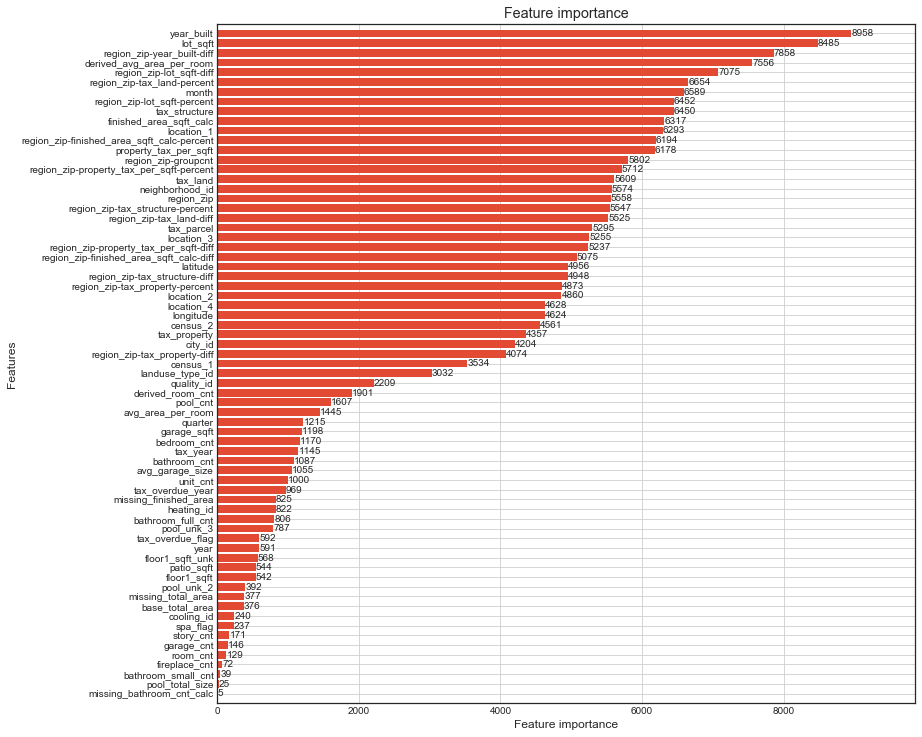

In [36]:
# Plot LightGBM feature importance
lgb.plot_importance(clf, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

In [ ]:
# Helper method for LightGBM hyperparameter tuning: Sweep a single hyperparameter
def sweep_hyperparam(param_name, sweep):
    lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
    lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

    train_scores = []
    val_scores = []
    for p in sweep:
        print(p)
        np.random.seed(42)
        random.seed(36)
        params[param_name] = p
        clf = lgb.train(params, lgb_train_set, verbose_eval=False,
                    valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                    categorical_feature=categorical_indices)
        train_scores.append(abs(clf.predict(X_train) - y_train).mean() * 100)
        val_scores.append(abs(clf.predict(X_val) - y_val).mean() * 100)

    for i in range(len(sweep)):
        print("{}: train {}, val {}".format(sweep[i], train_scores[i], val_scores[i]))

sweep_hyperparam('learning_rate', [0.0025, 0.003])

In [ ]:
lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

scores = []
for num_leaves in [127]:
    for min_data in [120]:
        for sub_feature in [0.5, 0.55, 0.6]:
            params['num_leaves'] = num_leaves
            params['min_data'] = min_data
            params['sub_feature'] = sub_feature
            
            np.random.seed(42)
            random.seed(36)
            clf = lgb.train(params, lgb_train_set, verbose_eval=False,
                    valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                    categorical_feature=categorical_indices)
            
            val_score = abs(clf.predict(X_val) - y_val).mean() * 100
            param_tuple = (num_leaves, min_data, sub_feature)
            
            print("{}: {}".format(param_tuple, val_score))
            scores.append((param_tuple, val_score))

In [ ]:
Train score: 5.030134340102275
Val score: 6.871510256507197

# Train on all data + Make predictions

In [45]:
# Train LightGBM on all given training data (preparing for submission)
del params['early_stopping_rounds']
params['num_boost_round'] = 2000
print(params)

outlier_threshold = 0.4
mask = (abs(lgb_y) <= outlier_threshold)
lgb_X = lgb_X[mask, :]
lgb_y = lgb_y[mask]

lgb_train_set = lgb.Dataset(lgb_X, label=lgb_y, feature_name=feature_names)
print("lgb_X: {}".format(lgb_X.shape))
print("lgb_y: {}".format(lgb_y.shape))

np.random.seed(42)
random.seed(36)
clf = lgb.train(params, lgb_train_set, verbose_eval=True,
                valid_sets=[lgb_train_set], valid_names=['train'],
                categorical_feature=categorical_indices)

{'objective': 'regression', 'metric': 'mae', 'num_threads': 4, 'boosting_type': 'gbdt', 'num_boost_round': 2000, 'learning_rate': 0.003, 'num_leaves': 127, 'min_data': 150, 'min_hessian': 0.001, 'max_depth': -1, 'max_bin': 255, 'sub_feature': 0.5, 'bagging_fraction': 0.7, 'bagging_freq': 50, 'min_data_per_group': 100, 'cat_smooth': 15.0, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'feature_fraction_seed': 2, 'bagging_seed': 3}
lgb_X: (164299, 69)
lgb_y: (164299,)


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 13, 21, 66, 67, 68]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	train's l1: 0.052661
[2]	train's l1: 0.052656
[3]	train's l1: 0.0526508
[4]	train's l1: 0.0526457
[5]	train's l1: 0.0526408
[6]	train's l1: 0.0526363
[7]	train's l1: 0.0526315
[8]	train's l1: 0.0526266
[9]	train's l1: 0.0526218
[10]	train's l1: 0.0526173
[11]	train's l1: 0.0526123
[12]	train's l1: 0.0526078
[13]	train's l1: 0.0526033
[14]	train's l1: 0.0525983
[15]	train's l1: 0.052594
[16]	train's l1: 0.0525892
[17]	train's l1: 0.0525848
[18]	train's l1: 0.0525803
[19]	train's l1: 0.0525757
[20]	train's l1: 0.052571
[21]	train's l1: 0.0525661
[22]	train's l1: 0.0525617
[23]	train's l1: 0.0525579
[24]	train's l1: 0.0525532
[25]	train's l1: 0.0525487
[26]	train's l1: 0.0525445
[27]	train's l1: 0.0525403
[28]	train's l1: 0.0525359
[29]	train's l1: 0.0525315
[30]	train's l1: 0.0525271
[31]	train's l1: 0.0525229
[32]	train's l1: 0.0525189
[33]	train's l1: 0.0525144
[34]	train's l1: 0.0525101
[35]	train's l1: 0.0525056
[36]	train's l1: 0.0525012
[37]	train's l1: 0.0524973
[38]	train's l

[308]	train's l1: 0.0517202
[309]	train's l1: 0.0517181
[310]	train's l1: 0.0517162
[311]	train's l1: 0.0517141
[312]	train's l1: 0.0517121
[313]	train's l1: 0.05171
[314]	train's l1: 0.0517081
[315]	train's l1: 0.0517061
[316]	train's l1: 0.051704
[317]	train's l1: 0.051702
[318]	train's l1: 0.0517003
[319]	train's l1: 0.0516985
[320]	train's l1: 0.0516963
[321]	train's l1: 0.0516944
[322]	train's l1: 0.0516926
[323]	train's l1: 0.0516907
[324]	train's l1: 0.0516887
[325]	train's l1: 0.0516869
[326]	train's l1: 0.0516849
[327]	train's l1: 0.051683
[328]	train's l1: 0.0516811
[329]	train's l1: 0.0516789
[330]	train's l1: 0.051677
[331]	train's l1: 0.051675
[332]	train's l1: 0.0516733
[333]	train's l1: 0.0516714
[334]	train's l1: 0.0516693
[335]	train's l1: 0.0516674
[336]	train's l1: 0.0516653
[337]	train's l1: 0.0516634
[338]	train's l1: 0.0516617
[339]	train's l1: 0.0516598
[340]	train's l1: 0.0516581
[341]	train's l1: 0.0516565
[342]	train's l1: 0.0516546
[343]	train's l1: 0.0516528

[605]	train's l1: 0.0512525
[606]	train's l1: 0.0512512
[607]	train's l1: 0.0512497
[608]	train's l1: 0.0512484
[609]	train's l1: 0.051247
[610]	train's l1: 0.0512457
[611]	train's l1: 0.0512443
[612]	train's l1: 0.0512429
[613]	train's l1: 0.0512413
[614]	train's l1: 0.05124
[615]	train's l1: 0.0512387
[616]	train's l1: 0.0512372
[617]	train's l1: 0.0512357
[618]	train's l1: 0.0512342
[619]	train's l1: 0.0512329
[620]	train's l1: 0.0512313
[621]	train's l1: 0.05123
[622]	train's l1: 0.0512287
[623]	train's l1: 0.0512274
[624]	train's l1: 0.0512261
[625]	train's l1: 0.0512248
[626]	train's l1: 0.0512236
[627]	train's l1: 0.0512223
[628]	train's l1: 0.0512209
[629]	train's l1: 0.0512194
[630]	train's l1: 0.0512182
[631]	train's l1: 0.0512169
[632]	train's l1: 0.0512155
[633]	train's l1: 0.0512142
[634]	train's l1: 0.0512127
[635]	train's l1: 0.0512114
[636]	train's l1: 0.0512102
[637]	train's l1: 0.0512091
[638]	train's l1: 0.0512077
[639]	train's l1: 0.0512064
[640]	train's l1: 0.05120

[902]	train's l1: 0.0508866
[903]	train's l1: 0.0508856
[904]	train's l1: 0.0508846
[905]	train's l1: 0.0508835
[906]	train's l1: 0.0508825
[907]	train's l1: 0.0508813
[908]	train's l1: 0.0508802
[909]	train's l1: 0.0508792
[910]	train's l1: 0.0508783
[911]	train's l1: 0.0508774
[912]	train's l1: 0.0508762
[913]	train's l1: 0.0508751
[914]	train's l1: 0.0508741
[915]	train's l1: 0.050873
[916]	train's l1: 0.0508719
[917]	train's l1: 0.0508709
[918]	train's l1: 0.0508698
[919]	train's l1: 0.0508688
[920]	train's l1: 0.0508679
[921]	train's l1: 0.0508667
[922]	train's l1: 0.0508656
[923]	train's l1: 0.0508645
[924]	train's l1: 0.0508634
[925]	train's l1: 0.0508622
[926]	train's l1: 0.0508613
[927]	train's l1: 0.0508602
[928]	train's l1: 0.0508592
[929]	train's l1: 0.0508581
[930]	train's l1: 0.0508571
[931]	train's l1: 0.050856
[932]	train's l1: 0.0508549
[933]	train's l1: 0.0508539
[934]	train's l1: 0.050853
[935]	train's l1: 0.0508519
[936]	train's l1: 0.050851
[937]	train's l1: 0.0508

[1197]	train's l1: 0.0505796
[1198]	train's l1: 0.0505785
[1199]	train's l1: 0.0505775
[1200]	train's l1: 0.0505765
[1201]	train's l1: 0.0505753
[1202]	train's l1: 0.0505743
[1203]	train's l1: 0.0505732
[1204]	train's l1: 0.0505722
[1205]	train's l1: 0.0505712
[1206]	train's l1: 0.0505702
[1207]	train's l1: 0.0505692
[1208]	train's l1: 0.050568
[1209]	train's l1: 0.0505669
[1210]	train's l1: 0.0505659
[1211]	train's l1: 0.0505648
[1212]	train's l1: 0.0505639
[1213]	train's l1: 0.050563
[1214]	train's l1: 0.0505619
[1215]	train's l1: 0.0505609
[1216]	train's l1: 0.0505598
[1217]	train's l1: 0.0505588
[1218]	train's l1: 0.0505578
[1219]	train's l1: 0.0505568
[1220]	train's l1: 0.0505558
[1221]	train's l1: 0.0505548
[1222]	train's l1: 0.0505537
[1223]	train's l1: 0.0505527
[1224]	train's l1: 0.0505517
[1225]	train's l1: 0.0505508
[1226]	train's l1: 0.0505498
[1227]	train's l1: 0.0505486
[1228]	train's l1: 0.0505476
[1229]	train's l1: 0.0505467
[1230]	train's l1: 0.0505456
[1231]	train's l

[1487]	train's l1: 0.0503012
[1488]	train's l1: 0.0503003
[1489]	train's l1: 0.0502994
[1490]	train's l1: 0.0502986
[1491]	train's l1: 0.0502978
[1492]	train's l1: 0.0502967
[1493]	train's l1: 0.0502958
[1494]	train's l1: 0.0502949
[1495]	train's l1: 0.050294
[1496]	train's l1: 0.050293
[1497]	train's l1: 0.0502921
[1498]	train's l1: 0.0502913
[1499]	train's l1: 0.0502904
[1500]	train's l1: 0.0502895
[1501]	train's l1: 0.0502886
[1502]	train's l1: 0.0502875
[1503]	train's l1: 0.0502865
[1504]	train's l1: 0.0502855
[1505]	train's l1: 0.0502845
[1506]	train's l1: 0.0502834
[1507]	train's l1: 0.0502825
[1508]	train's l1: 0.0502816
[1509]	train's l1: 0.0502806
[1510]	train's l1: 0.0502797
[1511]	train's l1: 0.0502788
[1512]	train's l1: 0.0502779
[1513]	train's l1: 0.0502771
[1514]	train's l1: 0.0502761
[1515]	train's l1: 0.0502751
[1516]	train's l1: 0.0502743
[1517]	train's l1: 0.0502734
[1518]	train's l1: 0.0502724
[1519]	train's l1: 0.0502716
[1520]	train's l1: 0.0502707
[1521]	train's l

[1773]	train's l1: 0.0500414
[1774]	train's l1: 0.0500406
[1775]	train's l1: 0.0500398
[1776]	train's l1: 0.0500388
[1777]	train's l1: 0.0500379
[1778]	train's l1: 0.050037
[1779]	train's l1: 0.0500361
[1780]	train's l1: 0.0500351
[1781]	train's l1: 0.0500342
[1782]	train's l1: 0.0500334
[1783]	train's l1: 0.0500327
[1784]	train's l1: 0.0500318
[1785]	train's l1: 0.0500311
[1786]	train's l1: 0.0500302
[1787]	train's l1: 0.0500293
[1788]	train's l1: 0.0500284
[1789]	train's l1: 0.0500276
[1790]	train's l1: 0.0500266
[1791]	train's l1: 0.0500258
[1792]	train's l1: 0.0500248
[1793]	train's l1: 0.050024
[1794]	train's l1: 0.0500231
[1795]	train's l1: 0.0500225
[1796]	train's l1: 0.0500217
[1797]	train's l1: 0.0500207
[1798]	train's l1: 0.0500199
[1799]	train's l1: 0.0500191
[1800]	train's l1: 0.0500183
[1801]	train's l1: 0.0500175
[1802]	train's l1: 0.0500166
[1803]	train's l1: 0.0500158
[1804]	train's l1: 0.050015
[1805]	train's l1: 0.0500142
[1806]	train's l1: 0.0500133
[1807]	train's l1

In [48]:
%%time
def predict_and_export(clf, features_2016, features_2017, file_name):
    # Construct DataFrame for prediction results
    submission_2016 = pd.DataFrame()
    submission_2017 = pd.DataFrame()
    submission_2016['ParcelId'] = features_2016.parcelid
    submission_2017['ParcelId'] = features_2017.parcelid
    
    # Construct features and make prediction
    test_features_2016 = lgb_drop_features(features_2016)
    test_features_2017 = lgb_drop_features(features_2017)
    
    # test_dates = ['2016-10-01', '2016-11-01', '2016-12-01', '2017-10-01', '2017-11-01', '2017-12-01']
    # test_columns = ['201610', '201611', '201612', '201710', '201711', '201712']
    test_dates = ['2016-10-01', '2017-10-01']
    test_columns = ['201610', '201710']
    
    for d, c in zip(test_dates, test_columns):
        print("Start predicting for {}".format(c))
        
        test_features = test_features_2016 if d[:4] == '2016' else test_features_2017
        test_features['transactiondate'] = d
        data_proc.add_simple_datetime_features(test_features)
        pred_test = [float(format(x, '.4f')) for x in clf.predict(test_features)]        
        if d[:4] == '2016':
            submission_2016[c] = pred_test
        else:
            submission_2017[c] = pred_test
        
        print("Finished predicting for {}".format(c))
    
    submission_2016['201611'] = submission_2016['201610']
    submission_2016['201612'] = submission_2016['201610']
    submission_2017['201711'] = submission_2017['201710']
    submission_2017['201712'] = submission_2017['201710']
    
    submission = submission_2016.merge(how='inner', right=submission_2017, on='ParcelId')
    
    print("Length of submission DataFrame: {}".format(len(submission)))
    print("Submission header:")
    print(submission.head())
    submission.to_csv(file_name, index=False)
    return submission  # Return the results so that we can analyze or sanity check it

submission = predict_and_export(clf, features_2016, features_2017, 'data/submission_180104_lgb_tuned.csv')
submission.head()

Start predicting for 201610
Finished predicting for 201610
Start predicting for 201710
Finished predicting for 201710
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147  0.0068  0.0068  0.0068  0.0114  0.0114  0.0114
1  10759547  0.0076  0.0076  0.0076  0.0094  0.0094  0.0094
2  10843547  0.0330  0.0330  0.0330  0.0475  0.0475  0.0475
3  10859147  0.0401  0.0401  0.0401  0.0369  0.0369  0.0369
4  10879947  0.0019  0.0019  0.0019  0.0011  0.0011  0.0011
CPU times: user 57min 26s, sys: 17.6 s, total: 57min 43s
Wall time: 15min 1s
